## Autoencoder 구현

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

In [2]:
# 시각화 패키지
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [3]:
# 커널 죽는거 방지
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
# 하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device: ", DEVICE)

Using Device:  cuda


In [5]:
# Fashion MNIST 학습 데이터셋만 사용
trainset = datasets.FashionMNIST(root='./.data/',
                                 train=True,
                                 download=True,
                                 transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=2)

In [6]:
# Autoencoder 클래스
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [7]:
# 모델, optimizer, Loss 정의
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [8]:
# 원본 데이터 시각화 (첫 번째 열)
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

In [9]:
# 학습 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28 * 28).to(DEVICE)
        y = x.view(-1, 28 * 28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[EPOCH 1]


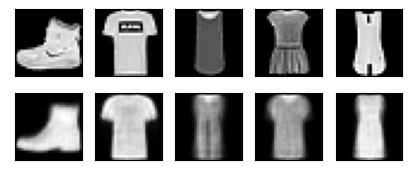

[EPOCH 2]


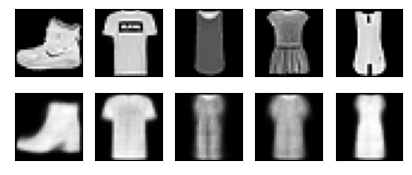

[EPOCH 3]


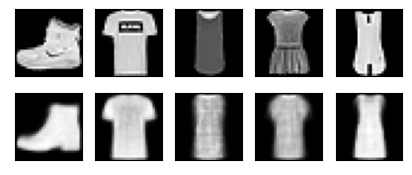

[EPOCH 4]


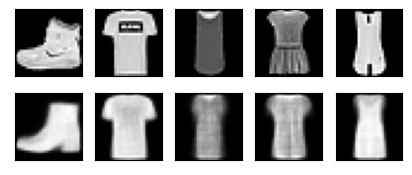

[EPOCH 5]


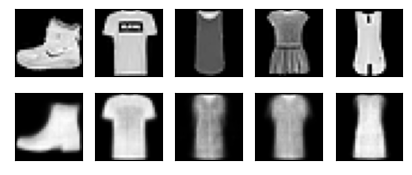

[EPOCH 6]


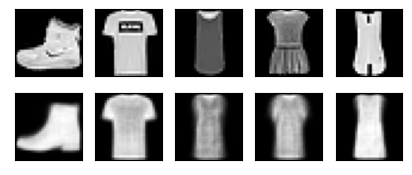

[EPOCH 7]


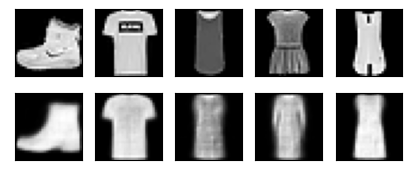

[EPOCH 8]


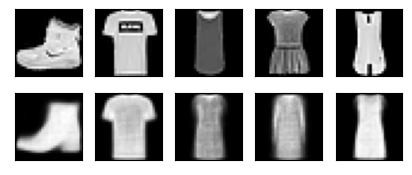

[EPOCH 9]


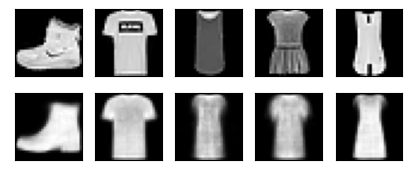

[EPOCH 10]


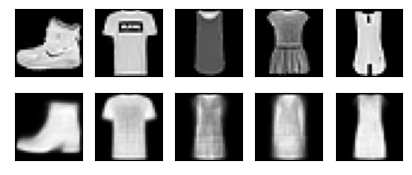

In [11]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)
    
    # 디코더에서 나온 이미지 시각화
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)
    
    # 원본과 디코딩 결과 시각화 비교
    f, a = plt.subplots(2, 5, figsize=(5,2))
    print("[EPOCH {}]".format(epoch))
    
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i], (28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i],
                        (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    
    plt.show()

## 잠재 변수 살펴보기

In [12]:
# 잠재 변수 3D 플롯 시각화
view_data = trainset.data[:200].view(-1, 28 * 28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

In [13]:
# 레이블
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

C:\Users\user\AppData\Local\Temp\ipykernel_13104\3119578524.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


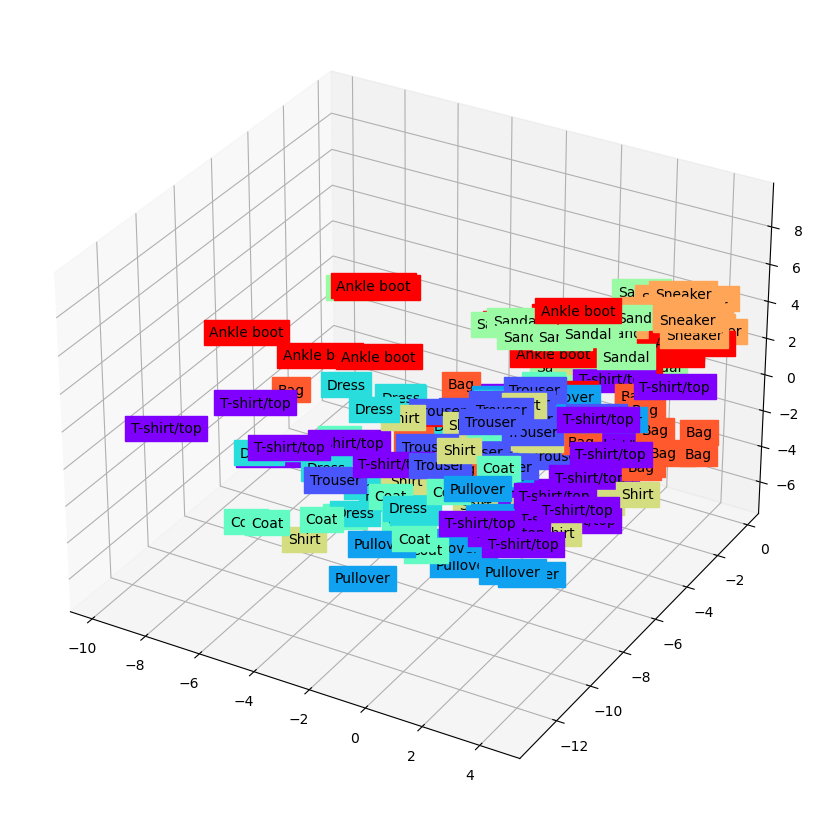

In [17]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255 * s / 9))
    ax.text(x, y, z, name, backgroundcolor=color)

    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())
    ax.set_zlim(Z.min(), Z.max())
plt.show()

## 망가진 이미지 복원하기

In [18]:
# 무작위 잡음 더하는 함수
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [19]:
# 학습 코드 수정
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        noisy_x = add_noise(x)
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        
        label = label.to(DEVICE)
        encoded, decoded = autoencoder(noisy_x)
        
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
    
    return avg_loss / len(train_loader)

In [20]:
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print("[EPOCH {} loss:{}]".format(epoch, loss))

[EPOCH 1 loss:0.022938553682729]
[EPOCH 2 loss:0.022401900741575498]
[EPOCH 3 loss:0.022236211612614108]
[EPOCH 4 loss:0.02224744920894853]
[EPOCH 5 loss:0.022104346644141272]
[EPOCH 6 loss:0.02206905751721437]
[EPOCH 7 loss:0.021983724512429886]
[EPOCH 8 loss:0.02192927485129345]
[EPOCH 9 loss:0.021976919119943306]
[EPOCH 10 loss:0.02189572703546044]


In [22]:
# 잡음 제거 시각화
testset = datasets.FashionMNIST(root='./.data/',
                                train=False,
                                download=True,
                                transform=transforms.ToTensor())

In [37]:
sample_data = testset.data[1234].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

In [38]:
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

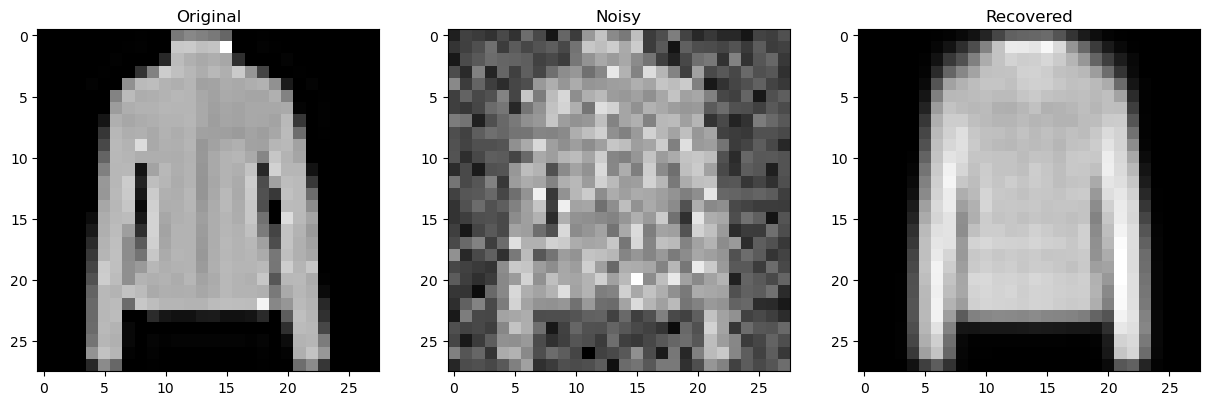

In [39]:
f, a = plt.subplots(1, 3, figsize=(15, 15))

# for 시각화, 이미지 --> 넘파이 행렬
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# 원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# 노이즈 추가한 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# 복원한 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()